In [25]:
import category_encoders as ce

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

## Defino funciones

In [26]:
def imputar(df):
    imp = SimpleImputer()
    cols = df._get_numeric_data().columns
    df_result = df.copy()
    for x in cols:
        df_result[x]=imp.fit_transform(df[[x]])
    return df_result

In [27]:
from sklearn.metrics import mean_absolute_error

def predecir(model, train_features, train_labels, test_features, test_labels):
    predict = model.predict(test_features)
    error = mean_absolute_error(test_labels, predict)
    score = model.score(test_features,test_labels)
    
    print('Entrenamiento: {:0.4f}%'.format(model.score(train_features, train_labels)*100))
    print('Testeo: {:0.4f}%.'.format(score*100))
    print('Mean abs error: {:0.4f}.'.format(error))

    
    return predict

In [28]:
def transformar(df,colums,func):
    for x in colums:
        df[x]=df[x].transform(lambda y: func(y))
        
columnas_para_transformar = ["metroscubiertos","metrostotales","metroscubiertostotales"]

#transformar(df1,columnas_para_transformar,np.sqrt)

## Importo dataset

In [29]:
df = pd.read_csv('../data/features.csv')
df_test = pd.read_csv('../data/test_features.csv')

df['fecha'] = pd.to_datetime(df['fecha'])
df['anio'] = df['fecha'].dt.year
df["mes"] = df['fecha'].dt.month
df["dia"] = df['fecha'].dt.day

In [30]:
df = df.drop(columns=["direccion","descripcion","titulo"])
df_test = df_test.drop(columns=["direccion","descripcion","titulo"])

df_ids = df_test["id"]
df = df.drop(columns=["id"])
df_test = df_test.drop(columns=["id"])



## Divido data set


In [31]:
x = df[df.columns.drop("precio")]
y = df['precio']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20)

#x_train, x_test, y_train = x, df_test, y

print(f"Original shapes: X={x.shape} y={y.shape}")
print(f"Train shapes: X={x_train.shape} y={y_train.shape}")
print(f"Test  shapes: X={x_test.shape}  y={y_test.shape}")

Original shapes: X=(240000, 40) y=(240000,)
Train shapes: X=(192000, 40) y=(192000,)
Test  shapes: X=(48000, 40)  y=(48000,)


 ## Completo los datos faltantes

In [32]:
oneHot = ['tipodepropiedad','provincia']
binary = ['ciudad']

In [33]:
#Completo los numericos
x_train = imputar(x_train)
x_test  = imputar(x_test )

#Completo los categoricos
imp = SimpleImputer(strategy="constant",fill_value="-")

x_train["tipodepropiedad"] = imp.fit_transform(x_train[["tipodepropiedad"]])
x_train["provincia"] = imp.fit_transform(x_train[["provincia"]])
x_train["ciudad"] = imp.fit_transform(x_train[["ciudad"]])

x_test["tipodepropiedad"] = imp.fit_transform(x_test[["tipodepropiedad"]])
x_test["provincia"] = imp.fit_transform(x_test[["provincia"]])
x_test["ciudad"] = imp.fit_transform(x_test[["ciudad"]])

In [34]:
x_train["metroscubiertostotales"]=x_train["metroscubiertos"]+x_train["metrostotales"]
x_train["ambientes"]=x_train["banos"]+x_train["habitaciones"]
x_train["ambientesygarage"]=x_train["banos"]+x_train["habitaciones"]+x_train["garages"]

x_test["metroscubiertostotales"]=x_test["metroscubiertos"]+x_test["metrostotales"]
x_test["ambientes"]=x_test["banos"]+x_test["habitaciones"]
x_test["ambientesygarage"]=x_test["banos"]+x_test["habitaciones"]+x_test["garages"]

 ## Genero los encodes

In [ ]:
data_cols_train = x_train._get_numeric_data().columns
baseline_data_train = x_train[data_cols]

data_cols_test = x_test._get_numeric_data().columns
baseline_data_test = x_test[data_cols]

In [55]:
encoder = ce.OneHotEncoder()


encoded = encoder.fit_transform(x_test[oneHot])
data_test = baseline_data_test.join(encoded)


encoded = encoder.fit_transform(x_train[oneHot])
data_train = baseline_data_train.join(encoded)


for a in data_train.columns[~data_train.columns.isin(data_test.columns)]:
    data_test[a] = 0

print (data_test.shape[1] == data_train.shape[1])

print(f"Train shapes: X={data_train.shape} y={data_train.shape}")
print(f"Test  shapes: X={data_test.shape}  y={data_test.shape}")

True
Train shapes: X=(192000, 95) y=(192000, 95)
Test  shapes: X=(48000, 95)  y=(48000, 95)


In [56]:
encoder = ce.BinaryEncoder()

encoded = encoder.fit_transform(x_train[binary])
data_train = data_train.join(encoded)


encoded = encoder.fit_transform(x_test[binary])
data_test = data_test.join(encoded)

print(f"Train shapes: X={data_train.shape} y={data_train.shape}")
print(f"Test  shapes: X={data_test.shape}  y={data_test.shape}")

Train shapes: X=(192000, 106) y=(192000, 106)
Test  shapes: X=(48000, 106)  y=(48000, 106)



## Modelo y entreno

In [57]:
from xgboost import XGBRegressor

model = XGBRegressor(n_estimators=400,max_depth=10,n_jobs=-1,objective="reg:squarederror")

In [58]:
model.fit(data_train, y_train)

/home/peter/.local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=None, n_estimators=400,
             n_jobs=-1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

## Predicciones

In [49]:
for a in data_train.columns[~data_train.columns.isin(data_test.columns)]:
    data_test[a] = 0

print (data_test.shape[1] == data_train.shape[1])

print(f"Train shapes: X={data_train.shape} y={data_train.shape}")
print(f"Test  shapes: X={data_test.shape}  y={data_test.shape}")

True
Train shapes: X=(192000, 106) y=(192000, 106)
Test  shapes: X=(48000, 106)  y=(48000, 106)


In [59]:
predecir(model,data_train,y_train,data_test,y_test)

ValueError: feature_names mismatch: ['index', 'antiguedad', 'habitaciones', 'garages', 'banos', 'metroscubiertos', 'metrostotales', 'idzona', 'gimnasio', 'usosmultiples', 'piscina', 'escuelascercanas', 'centroscomercialescercanos', 'anio', 'mes', 'dia', 'excelente', 'centro', 'patio', 'hermosa', 'grande', 'universidad', 'ilum', 'seguridad', 'tienda', 'comedor', 'lujo', 'servicio', 'remodelada', 'autos', 'completo', 'cerca de', 'con vista', 'avenida', 'largo descripcion', 'metroscubiertostotales', 'ambientes', 'ambientesygarage', 'tipodepropiedad_1', 'tipodepropiedad_2', 'tipodepropiedad_3', 'tipodepropiedad_4', 'tipodepropiedad_5', 'tipodepropiedad_6', 'tipodepropiedad_7', 'tipodepropiedad_8', 'tipodepropiedad_9', 'tipodepropiedad_10', 'tipodepropiedad_11', 'tipodepropiedad_12', 'tipodepropiedad_13', 'tipodepropiedad_14', 'tipodepropiedad_15', 'tipodepropiedad_16', 'tipodepropiedad_17', 'tipodepropiedad_18', 'tipodepropiedad_19', 'tipodepropiedad_20', 'tipodepropiedad_21', 'tipodepropiedad_22', 'tipodepropiedad_23', 'tipodepropiedad_24', 'provincia_1', 'provincia_2', 'provincia_3', 'provincia_4', 'provincia_5', 'provincia_6', 'provincia_7', 'provincia_8', 'provincia_9', 'provincia_10', 'provincia_11', 'provincia_12', 'provincia_13', 'provincia_14', 'provincia_15', 'provincia_16', 'provincia_17', 'provincia_18', 'provincia_19', 'provincia_20', 'provincia_21', 'provincia_22', 'provincia_23', 'provincia_24', 'provincia_25', 'provincia_26', 'provincia_27', 'provincia_28', 'provincia_29', 'provincia_30', 'provincia_31', 'provincia_32', 'provincia_33', 'ciudad_0', 'ciudad_1', 'ciudad_2', 'ciudad_3', 'ciudad_4', 'ciudad_5', 'ciudad_6', 'ciudad_7', 'ciudad_8', 'ciudad_9', 'ciudad_10'] ['index', 'antiguedad', 'habitaciones', 'garages', 'banos', 'metroscubiertos', 'metrostotales', 'idzona', 'gimnasio', 'usosmultiples', 'piscina', 'escuelascercanas', 'centroscomercialescercanos', 'anio', 'mes', 'dia', 'excelente', 'centro', 'patio', 'hermosa', 'grande', 'universidad', 'ilum', 'seguridad', 'tienda', 'comedor', 'lujo', 'servicio', 'remodelada', 'autos', 'completo', 'cerca de', 'con vista', 'avenida', 'largo descripcion', 'metroscubiertostotales', 'ambientes', 'ambientesygarage', 'tipodepropiedad_1', 'tipodepropiedad_2', 'tipodepropiedad_3', 'tipodepropiedad_4', 'tipodepropiedad_5', 'tipodepropiedad_6', 'tipodepropiedad_7', 'tipodepropiedad_8', 'tipodepropiedad_9', 'tipodepropiedad_10', 'tipodepropiedad_11', 'tipodepropiedad_12', 'tipodepropiedad_13', 'tipodepropiedad_14', 'tipodepropiedad_15', 'tipodepropiedad_16', 'tipodepropiedad_17', 'tipodepropiedad_18', 'tipodepropiedad_19', 'tipodepropiedad_20', 'tipodepropiedad_21', 'tipodepropiedad_22', 'tipodepropiedad_23', 'provincia_1', 'provincia_2', 'provincia_3', 'provincia_4', 'provincia_5', 'provincia_6', 'provincia_7', 'provincia_8', 'provincia_9', 'provincia_10', 'provincia_11', 'provincia_12', 'provincia_13', 'provincia_14', 'provincia_15', 'provincia_16', 'provincia_17', 'provincia_18', 'provincia_19', 'provincia_20', 'provincia_21', 'provincia_22', 'provincia_23', 'provincia_24', 'provincia_25', 'provincia_26', 'provincia_27', 'provincia_28', 'provincia_29', 'provincia_30', 'provincia_31', 'provincia_32', 'provincia_33', 'tipodepropiedad_24', 'ciudad_0', 'ciudad_1', 'ciudad_2', 'ciudad_3', 'ciudad_4', 'ciudad_5', 'ciudad_6', 'ciudad_7', 'ciudad_8', 'ciudad_9', 'ciudad_10']

ValueError: shape mismatch: objects cannot be broadcast to a single shape

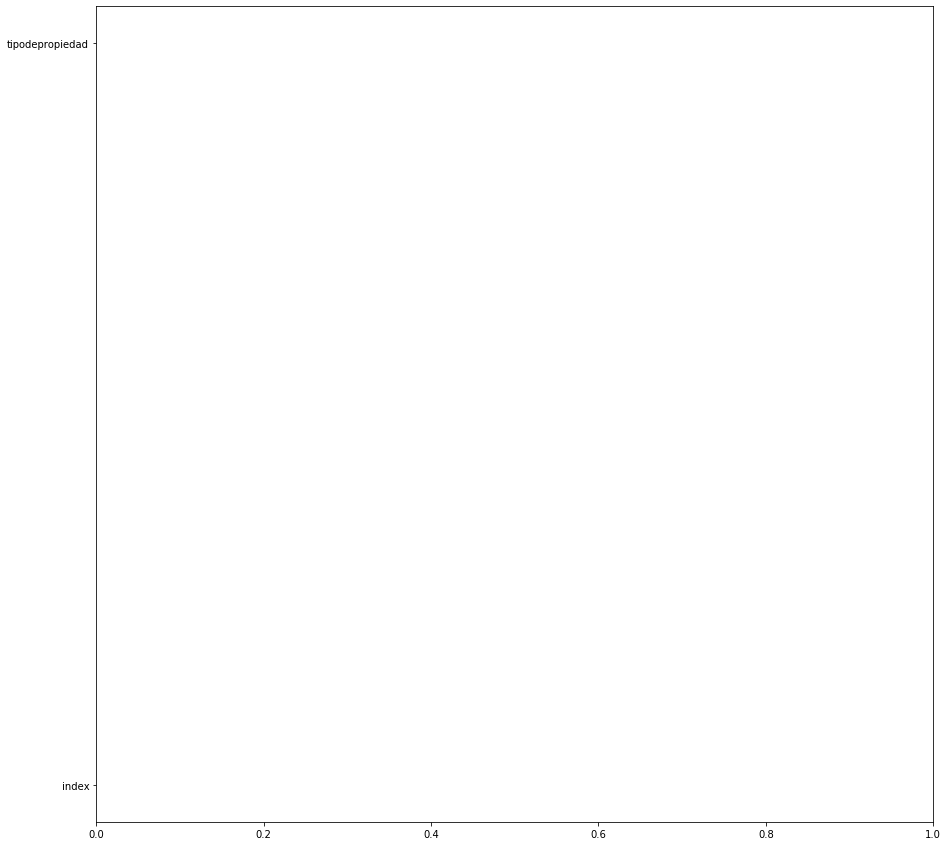

In [18]:
plt.rcParams["figure.figsize"] = [15, 15]

importancia = model.feature_importances_
ax = plt.barh(x_train.columns, importancia)

In [29]:
#Predigo los precios
predict = model.predict(data_test)

In [30]:
result = df_ids.astype("int32").to_frame()
result["target"] = predict.astype("int32")

In [31]:
result = df_ids.astype("int32").to_frame()
result["target"] = predict.astype("int32")
result.to_csv("../data/results/resultRF_Features.csv", index=False)